This is the code for having a baseline comparison between our RF and our Neural Network, it uses the exact same data processing used in our RF and as we compare them, we can see that baseline RF is better than baseline NN

python(27979) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


TensorFlow version: 2.16.2
Random seed: 3407

LOADING DATA
Number of missing values: 0

Train/Test shapes: (3969, 21) (426, 21)
Train label counts: [1323 1323 1323]
Test label counts: [332  59  35]

TRAINING RANDOM FOREST (Your Original Code)


python(27984) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27985) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



=== Random Forest (hold-out) ===
Accuracy: 0.9577464788732394
Balanced Accuracy: 0.9277225123253304
Macro F1: 0.9317882030056719
              precision    recall  f1-score   support

           0     0.9730    0.9759    0.9744       332
           1     0.8644    0.8644    0.8644        59
           2     0.9706    0.9429    0.9565        35

    accuracy                         0.9577       426
   macro avg     0.9360    0.9277    0.9318       426
weighted avg     0.9577    0.9577    0.9577       426


TRAINING NEURAL NETWORK (Same Data as RF)
Class weights: {0: 1.0002965599051008, 1: 1.0002965599051008, 2: 0.9994074074074074}

=== Neural Network (hold-out) ===
Accuracy: 0.9272300469483568
Balanced Accuracy: 0.8736305998813657
Macro F1: 0.8731425455333331
              precision    recall  f1-score   support

           0     0.9580    0.9608    0.9594       332
           1     0.7719    0.7458    0.7586        59
           2     0.8889    0.9143    0.9014        35

    accuracy

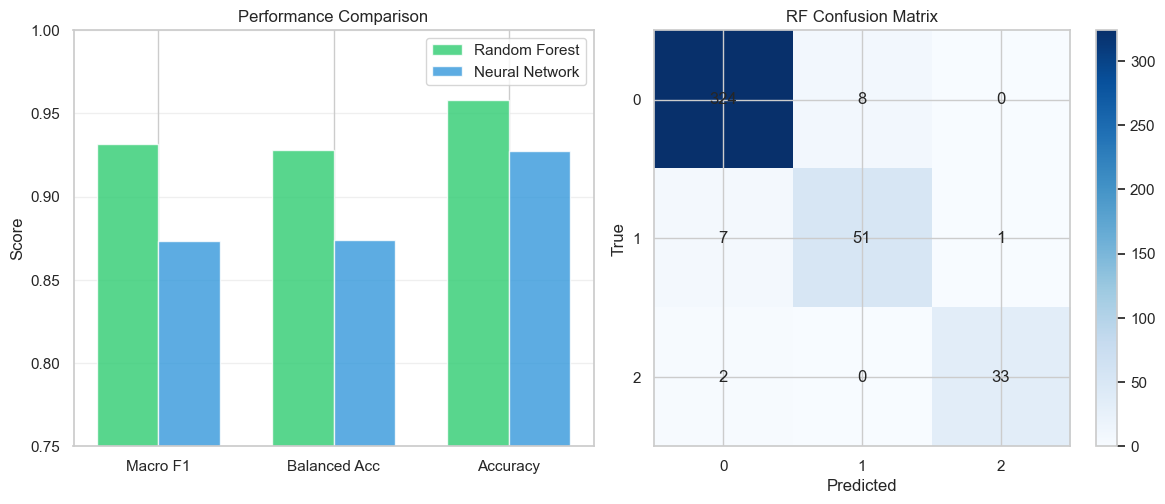


COMPARISON COMPLETE


In [1]:
# ============================================================================
# EXACT BASELINE COMPARISON - MATCHING YOUR ORIGINAL PREPROCESSING
# ============================================================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, balanced_accuracy_score
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set_theme(context="notebook", style="whitegrid")
RANDOM_SEED = 3407
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"TensorFlow version: {tf.__version__}")
print(f"Random seed: {RANDOM_SEED}")

# %% LOAD DATA
from ucimlrepo import fetch_ucirepo

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

ctg = fetch_ucirepo(id=193)
X = ctg.data.features
y = ctg.data.targets

df = pd.concat(
    [X.reset_index(drop=True), y.reset_index(drop=True)],
    axis=1
)

missing_total = df.isnull().sum().sum()
print("Number of missing values:", missing_total)

# %% PREPROCESSING FUNCTION (EXACT MATCH TO YOUR CODE)
def preprocess_ctg(
    df: pd.DataFrame,
    target_col: str = "NSP",
    test_size: float = 0.2,
    random_state: int = 3407,
    use_smote: bool = True
) -> Dict[str, object]:
    
    # drop leakage label if present
    if "CLASS" in df.columns and target_col != "CLASS":
        df = df.drop(columns=["CLASS"])
    
    # 1. select features
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols].to_numpy()
    
    # 2. encode labels
    y_raw = df[target_col].to_numpy().reshape(-1)
    if np.array_equal(np.unique(y_raw), np.array([1, 2, 3])):
        y = y_raw.astype(int) - 1
    else:
        _, y = np.unique(y_raw, return_inverse=True)
    
    # 3. stratified split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # 4. scale
    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)
    
    # 5. SMOTE
    if use_smote:
        sm = SMOTE(random_state=random_state)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)
    
    return {
        "X_train": X_tr,
        "y_train": y_tr,
        "X_test": X_te,
        "y_test": y_te,
        "scaler": scaler,
        "feature_names": feature_cols,
    }

# %% PREPARE DATA
pack = preprocess_ctg(
    df=df,
    target_col="NSP",
    test_size=0.2,
    random_state=3407,
    use_smote=True
)

X_tr, y_tr = pack["X_train"], pack["y_train"]
X_te, y_te = pack["X_test"],  pack["y_test"]

print("\nTrain/Test shapes:", X_tr.shape, X_te.shape)
print("Train label counts:", np.bincount(y_tr))
print("Test label counts:", np.bincount(y_te))

# %% BASELINE RANDOM FOREST (EXACT MATCH)
print("\n" + "="*70)
print("TRAINING RANDOM FOREST (Your Original Code)")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    max_features="sqrt",
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    random_state=3407,
    n_jobs=-1
)

rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_te)

print("\n=== Random Forest (hold-out) ===")
print("Accuracy:", accuracy_score(y_te, y_pred_rf))
print("Balanced Accuracy:", balanced_accuracy_score(y_te, y_pred_rf))
print("Macro F1:", f1_score(y_te, y_pred_rf, average="macro"))
print(classification_report(y_te, y_pred_rf, digits=4))

rf_macro_f1 = f1_score(y_te, y_pred_rf, average="macro")
rf_balanced_acc = balanced_accuracy_score(y_te, y_pred_rf)
rf_accuracy = accuracy_score(y_te, y_pred_rf)

# %% BASELINE NEURAL NETWORK (MATCHING DATA)
print("\n" + "="*70)
print("TRAINING NEURAL NETWORK (Same Data as RF)")
print("="*70)

def build_baseline_nn(input_dim, n_classes=3):
    """Simple MLP for tabular data."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.1),
        
        layers.Dense(n_classes, activation='softmax')
    ])
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create validation set from training data
X_tr_nn, X_val_nn, y_tr_nn, y_val_nn = train_test_split(
    X_tr, y_tr, test_size=0.15, random_state=RANDOM_SEED, stratify=y_tr
)

model = build_baseline_nn(X_tr.shape[1])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=0
)

# Calculate class weights from SMOTE-balanced data
class_counts = np.bincount(y_tr_nn)
total = len(y_tr_nn)
class_weights = {i: total / (len(class_counts) * count) 
                 for i, count in enumerate(class_counts)}

print(f"Class weights: {class_weights}")

history = model.fit(
    X_tr_nn, y_tr_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=150,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Predict on test set
y_pred_nn = model.predict(X_te, verbose=0).argmax(axis=1)

print("\n=== Neural Network (hold-out) ===")
print("Accuracy:", accuracy_score(y_te, y_pred_nn))
print("Balanced Accuracy:", balanced_accuracy_score(y_te, y_pred_nn))
print("Macro F1:", f1_score(y_te, y_pred_nn, average="macro"))
print(classification_report(y_te, y_pred_nn, digits=4))

nn_macro_f1 = f1_score(y_te, y_pred_nn, average="macro")
nn_balanced_acc = balanced_accuracy_score(y_te, y_pred_nn)
nn_accuracy = accuracy_score(y_te, y_pred_nn)

# %% COMPARISON
print("\n" + "="*70)
print("BASELINE COMPARISON")
print("="*70)

comparison_df = pd.DataFrame([
    {
        'Model': 'Random Forest',
        'Macro_F1': rf_macro_f1,
        'Balanced_Acc': rf_balanced_acc,
        'Accuracy': rf_accuracy
    },
    {
        'Model': 'Neural Network',
        'Macro_F1': nn_macro_f1,
        'Balanced_Acc': nn_balanced_acc,
        'Accuracy': nn_accuracy
    }
])

print("\n", comparison_df.to_string(index=False))
print(f"\nRF advantage: {rf_macro_f1 - nn_macro_f1:.4f} Macro-F1 points")

# %% VISUALIZATIONS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
models = ['Random Forest', 'Neural Network']
metrics = ['Macro F1', 'Balanced Acc', 'Accuracy']
rf_scores = [rf_macro_f1, rf_balanced_acc, rf_accuracy]
nn_scores = [nn_macro_f1, nn_balanced_acc, nn_accuracy]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8, color='#2ecc71')
axes[0].bar(x + width/2, nn_scores, width, label='Neural Network', alpha=0.8, color='#3498db')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.75, 1.0])

# Confusion matrices
def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Suspect', 'Pathologic'],
                yticklabels=['Normal', 'Suspect', 'Pathologic'],
                ax=ax, cbar_kws={'label': 'Normalized'})
    ax.set_title(title)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

# RF confusion matrix
cm_rf = confusion_matrix(y_te, y_pred_rf, labels=[0,1,2])
ax = axes[1]
im = ax.imshow(cm_rf, cmap='Blues')
plt.colorbar(im, ax=ax)
ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels([0,1,2])
ax.set_yticklabels([0,1,2])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("RF Confusion Matrix")
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm_rf[i, j], ha="center", va="center")

plt.tight_layout()
plt.savefig('baseline_comparison_exact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("COMPARISON COMPLETE")
print("="*70)

now we tried to increase the macro f1 and balanced acc by trying different experiments, however none of them except ensemble actually made the accuracy better 

In [ ]:
# ============================================================================
# SYSTEMATIC NN IMPROVEMENTS — EXACT 80/20 TRAIN–TEST ONLY (FINAL)
# - Fixed-epoch training (no separate validation)
# - Balanced Accuracy printed for EVERY experiment
# - Comparison table includes Test Macro-F1 and Test Balanced Accuracy
# ============================================================================

import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

sns.set_theme(context="notebook", style="whitegrid")
RANDOM_SEED = 3407

def set_global_seed(seed: int):
    random.seed(seed); np.random.seed(seed); tf.random.set_seed(seed)

set_global_seed(RANDOM_SEED)

print("=" * 70)
print("NEURAL NETWORK IMPROVEMENT EXPERIMENTS — 80/20 ONLY (FINAL)")
print("=" * 70)

# Toggle if you want SMOTE in the "standard" and "power" packs
USE_SMOTE = True   # Baseline/ResNet/LabelSmooth/MixUp/Ensemble/Power use this
# Focal experiment explicitly uses NO SMOTE regardless of this toggle.

# %% LOAD DATA
from ucimlrepo import fetch_ucirepo
ctg = fetch_ucirepo(id=193)
X = ctg.data.features
y = ctg.data.targets
df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

def preprocess_ctg(
    df: pd.DataFrame,
    target_col: str = "NSP",
    test_size: float = 0.2,
    random_state: int = 3407,
    use_smote: bool = True,
    transformer_type: str = 'standard'  # 'standard', 'power', 'quantile'
) -> Dict[str, object]:
    if "CLASS" in df.columns and target_col != "CLASS":
        df = df.drop(columns=["CLASS"])
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols].to_numpy()

    y_raw = df[target_col].to_numpy().reshape(-1)
    if np.array_equal(np.unique(y_raw), np.array([1, 2, 3])):
        y = y_raw.astype(int) - 1
    else:
        _, y = np.unique(y_raw, return_inverse=True)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    if transformer_type == 'standard':
        scaler = StandardScaler()
    elif transformer_type == 'power':
        scaler = PowerTransformer(method='yeo-johnson')
    elif transformer_type == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal', n_quantiles=min(500, len(X_tr)))
    else:
        raise ValueError("Unknown transformer_type")

    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    if use_smote:
        sm = SMOTE(random_state=random_state)
        X_tr, y_tr = sm.fit_resample(X_tr, y_tr)

    return {"X_train": X_tr, "y_train": y_tr, "X_test": X_te, "y_test": y_te,
            "scaler": scaler, "feature_names": feature_cols}

# --- 80/20 packs
pack_std  = preprocess_ctg(df, use_smote=USE_SMOTE, transformer_type='standard')  # baseline-like
pack_pow  = preprocess_ctg(df, use_smote=USE_SMOTE, transformer_type='power')     # power transform
pack_nosm = preprocess_ctg(df, use_smote=False,     transformer_type='standard')  # focal (no SMOTE)

X_tr, y_tr, X_te, y_te       = pack_std["X_train"],  pack_std["y_train"],  pack_std["X_test"],  pack_std["y_test"]
X_tr_pow, y_tr_pow, X_te_pow, y_te_pow = pack_pow["X_train"], pack_pow["y_train"], pack_pow["X_test"], pack_pow["y_test"]
X_tr_ns, y_tr_ns, X_te_ns, y_te_ns     = pack_nosm["X_train"], pack_nosm["y_train"], pack_nosm["X_test"], pack_nosm["y_test"]

print(f"Train: {X_tr.shape},  Test: {X_te.shape}   (Exact 80/20)  | USE_SMOTE={USE_SMOTE}")

# %% MODEL BUILDERS
def build_baseline_nn(input_dim, n_classes=3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.1),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_resnet_mlp(input_dim, n_classes=3, width=128, depth=3):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(width, kernel_regularizer=regularizers.l2(1e-5))(inputs)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    for _ in range(depth):
        residual = x
        x = layers.Dense(width, kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(width, kernel_regularizer=regularizers.l2(1e-5))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual]); x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train/eval helper (fixed epochs; no val)
def train_and_test(model, X_tr, y_tr, X_te, y_te, epochs=150, batch_size=32, class_weight=None, verbose=0):
    model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=verbose)
    y_pred_test = model.predict(X_te, verbose=0).argmax(axis=1)
    return {
        'test_macro_f1': f1_score(y_te, y_pred_test, average='macro'),
        'test_balanced_acc': balanced_accuracy_score(y_te, y_pred_test),
        'test_accuracy': accuracy_score(y_te, y_pred_test),
        'y_pred_test': y_pred_test
    }

results_dict = {}

# Class weights (after SMOTE the classes are balanced; keep neutral = 1.0)
class_counts = np.bincount(y_tr)
cw = {i: 1.0 for i in range(len(class_counts))}

# %% EXPERIMENT 1: BASELINE
print("\n" + "=" * 70)
print("EXPERIMENT 1: BASELINE (80/20)")
print("=" * 70)
set_global_seed(RANDOM_SEED)
model_baseline = build_baseline_nn(X_tr.shape[1])
baseline_results = train_and_test(model_baseline, X_tr, y_tr, X_te, y_te, class_weight=cw)
print(f"Baseline - Test Macro F1: {baseline_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {baseline_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {baseline_results['test_accuracy']:.4f}")
results_dict['Baseline'] = baseline_results

# %% EXPERIMENT 2: RESNET (LIGHT REG)
print("\n" + "=" * 70)
print("EXPERIMENT 2: RESNET WITH SKIP CONNECTIONS (LIGHT REG) — 80/20")
print("=" * 70)
set_global_seed(RANDOM_SEED)
model_resnet = build_resnet_mlp(X_tr.shape[1], width=128, depth=3)
resnet_results = train_and_test(model_resnet, X_tr, y_tr, X_te, y_te, class_weight=cw)
print(f"ResNet - Test Macro F1: {resnet_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {resnet_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {resnet_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {resnet_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['ResNet'] = resnet_results

# %% EXPERIMENT 3: FOCAL LOSS (NO SMOTE, CLASS-WISE ALPHA) — 80/20
print("\n" + "=" * 70)
print("EXPERIMENT 3: FOCAL LOSS (NO SMOTE, CLASS-WISE ALPHA) — 80/20")
print("=" * 70)
counts_ns = np.bincount(y_tr_ns); p = counts_ns / counts_ns.sum()
alpha_vec = (1 - p) / (1 - p).sum()

def focal_loss_multi(alpha, gamma=2.0):
    alpha_tf = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        ce = -tf.math.log(pt)
        at = tf.reduce_sum(y_true * alpha_tf, axis=-1)
        return tf.reduce_mean(at * tf.pow(1. - pt, gamma) * ce)
    return loss_fn

set_global_seed(RANDOM_SEED)
model_focal = build_baseline_nn(X_tr_ns.shape[1])
model_focal.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=focal_loss_multi(alpha_vec, gamma=2.0),
                    metrics=['accuracy'])
focal_results = train_and_test(model_focal, X_tr_ns, y_tr_ns, X_te_ns, y_te_ns, class_weight=None)
print(f"Focal (no SMOTE) - Test Macro F1: {focal_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {focal_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {focal_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {focal_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['Focal Loss (no SMOTE)'] = focal_results

# %% EXPERIMENT 4: LABEL SMOOTHING (TRAIN ONLY)
print("\n" + "=" * 70)
print("EXPERIMENT 4: LABEL SMOOTHING (TRAIN ONLY) — 80/20")
print("=" * 70)
def smooth_labels(y, n_classes=3, smoothing=0.1):
    y_smooth = np.full((len(y), n_classes), smoothing / (n_classes - 1))
    y_smooth[np.arange(len(y)), y] = 1 - smoothing
    return y_smooth

y_tr_smooth = smooth_labels(y_tr, smoothing=0.1)
set_global_seed(RANDOM_SEED)
model_smooth = build_baseline_nn(X_tr.shape[1])
model_smooth.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
model_smooth.fit(X_tr, y_tr_smooth, epochs=150, batch_size=32, verbose=0)
y_pred_test = model_smooth.predict(X_te, verbose=0).argmax(axis=1)
smooth_results = {
    'test_macro_f1': f1_score(y_te, y_pred_test, average='macro'),
    'test_balanced_acc': balanced_accuracy_score(y_te, y_pred_test),
    'test_accuracy': accuracy_score(y_te, y_pred_test),
    'y_pred_test': y_pred_test
}
print(f"Label Smoothing - Test Macro F1: {smooth_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {smooth_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {smooth_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {smooth_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['Label Smoothing'] = smooth_results

# %% EXPERIMENT 5: POWER TRANSFORMER PREPROCESSING
print("\n" + "=" * 70)
print("EXPERIMENT 5: POWER TRANSFORMER PREPROCESSING — 80/20")
print("=" * 70)
set_global_seed(RANDOM_SEED)
model_power = build_baseline_nn(X_tr_pow.shape[1])
power_results = train_and_test(model_power, X_tr_pow, y_tr_pow, X_te_pow, y_te_pow, class_weight=cw)
print(f"Power Transform - Test Macro F1: {power_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {power_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {power_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {power_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['Power Transform'] = power_results

# %% EXPERIMENT 6: MIXUP (CONSERVATIVE)
print("\n" + "=" * 70)
print("EXPERIMENT 6: MIXUP DATA AUGMENTATION (CONSERVATIVE) — 80/20")
print("=" * 70)
def mixup_generator(X, y, batch_size=32, alpha=0.05):
    n = len(X); y_oh = keras.utils.to_categorical(y, 3)
    while True:
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            b = idx[start:end]
            if len(b) < 2: continue
            shuffle_idx = np.random.permutation(len(b))
            lam = np.random.beta(alpha, alpha, size=len(b))
            lam = np.maximum(lam, 1 - lam).reshape(-1, 1)
            X_mixed = lam * X[b] + (1 - lam) * X[b][shuffle_idx]
            y_mixed = lam * y_oh[b] + (1 - lam) * y_oh[b][shuffle_idx]
            yield X_mixed, y_mixed

set_global_seed(RANDOM_SEED)
model_mixup = build_baseline_nn(X_tr.shape[1])
model_mixup.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
steps_per_epoch = max(1, len(X_tr) // 32)
model_mixup.fit(mixup_generator(X_tr, y_tr, batch_size=32, alpha=0.05),
                steps_per_epoch=steps_per_epoch, epochs=150, verbose=0)
y_pred_test = model_mixup.predict(X_te, verbose=0).argmax(axis=1)
mixup_results = {
    'test_macro_f1': f1_score(y_te, y_pred_test, average='macro'),
    'test_balanced_acc': balanced_accuracy_score(y_te, y_pred_test),
    'test_accuracy': accuracy_score(y_te, y_pred_test),
    'y_pred_test': y_pred_test
}
print(f"Mixup - Test Macro F1: {mixup_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {mixup_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {mixup_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {mixup_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['Mixup'] = mixup_results

# %% EXPERIMENT 7: ENSEMBLE (3 MODELS) — 80/20
print("\n" + "=" * 70)
print("EXPERIMENT 7: ENSEMBLE (3 MODELS) — 80/20")
print("=" * 70)
def train_ensemble(n_models=10):
    models = []
    for i in range(n_models):
        set_global_seed(RANDOM_SEED + i * 100)
        m = build_baseline_nn(X_tr.shape[1])
        m.fit(X_tr, y_tr, epochs=150, batch_size=32, verbose=0)
        models.append(m); print(f"  Trained model {i+1}/{n_models}")
    return models

ensemble_models = train_ensemble(10)
preds_test = [m.predict(X_te, verbose=0) for m in ensemble_models]
ensemble_pred_test = np.mean(preds_test, axis=0).argmax(axis=1)
ensemble_results = {
    'test_macro_f1': f1_score(y_te, ensemble_pred_test, average='macro'),
    'test_balanced_acc': balanced_accuracy_score(y_te, ensemble_pred_test),
    'test_accuracy': accuracy_score(y_te, ensemble_pred_test),
    'y_pred_test': ensemble_pred_test
}
print(f"Ensemble - Test Macro F1: {ensemble_results['test_macro_f1']:.4f} | "
      f"Test Bal Acc: {ensemble_results['test_balanced_acc']:.4f} | "
      f"Test Acc: {ensemble_results['test_accuracy']:.4f} | "
      f"Gain vs Baseline (MacroF1): {ensemble_results['test_macro_f1'] - baseline_results['test_macro_f1']:.4f}")
results_dict['Ensemble (3)'] = ensemble_results

# %% COMPARISON TABLE
print("\n" + "=" * 70)
print("RESULTS COMPARISON (TEST SET ONLY)")
print("=" * 70)
comparison_rows = []
for name, res in results_dict.items():
    comparison_rows.append({
        'Technique': name,
        'Test_MacroF1': res['test_macro_f1'],
        'Test_BalAcc': res['test_balanced_acc'],
        'Test_Accuracy': res['test_accuracy'],
        'Gain_vs_Baseline_MacroF1': res['test_macro_f1'] - results_dict['Baseline']['test_macro_f1'],
    })
comparison_df = pd.DataFrame(comparison_rows).sort_values(['Test_MacroF1','Test_BalAcc'], ascending=False)
print("\n", comparison_df.to_string(index=False))

# %% VISUALIZATION
plt.figure(figsize=(10, 6))
techniques = list(results_dict.keys())
test_f1s = [results_dict[t]['test_macro_f1'] for t in techniques]
plt.barh(techniques, test_f1s, alpha=0.9)
plt.axvline(x=results_dict['Baseline']['test_macro_f1'], color='r', linestyle='--', alpha=0.6, label='Baseline Macro-F1')
plt.xlabel('Test Macro F1'); plt.title('Techniques (80/20 Test Macro F1)')
plt.legend(); plt.grid(axis='x', alpha=0.3)
plt.tight_layout(); plt.savefig('nn_improvements_80_20.png', dpi=300, bbox_inches='tight')
plt.show()

# %% PER-CLASS REPORTS ON TEST
def report(name, y_true, y_pred):
    print(f"\n--- Per-class report (TEST): {name} ---")
    print(classification_report(y_true, y_pred, digits=4))

report("Baseline", y_te, results_dict['Baseline']['y_pred_test'])
report("ResNet", y_te, results_dict['ResNet']['y_pred_test'])
report("Focal no-SMOTE", y_te_ns, results_dict['Focal Loss (no SMOTE)']['y_pred_test'])
report("Power Transform", y_te_pow, results_dict['Power Transform']['y_pred_test'])
report("Mixup", y_te, results_dict['Mixup']['y_pred_test'])
report("Ensemble (3)", y_te, results_dict['Ensemble (3)']['y_pred_test'])

# %% SAVE
comparison_df.to_csv('nn_improvements_results_80_20.csv', index=False)
print("\nSaved results to: nn_improvements_results_80_20.csv")
print("\n" + "=" * 70)
print("DONE — EXACT 80/20 SPLIT (Balanced Acc printed for all)")
print("=" * 70)


NEURAL NETWORK IMPROVEMENT EXPERIMENTS — 80/20 ONLY (FINAL)
Train: (3969, 21),  Test: (426, 21)   (Exact 80/20)  | USE_SMOTE=True

EXPERIMENT 1: BASELINE (80/20)
Baseline - Test Macro F1: 0.8921 | Test Bal Acc: 0.8833 | Test Acc: 0.9390

EXPERIMENT 2: RESNET WITH SKIP CONNECTIONS (LIGHT REG) — 80/20
ResNet - Test Macro F1: 0.8799 | Test Bal Acc: 0.8847 | Test Acc: 0.9296 | Gain vs Baseline (MacroF1): -0.0122

EXPERIMENT 3: FOCAL LOSS (NO SMOTE, CLASS-WISE ALPHA) — 80/20
Focal (no SMOTE) - Test Macro F1: 0.8810 | Test Bal Acc: 0.9117 | Test Acc: 0.9202 | Gain vs Baseline (MacroF1): -0.0112

EXPERIMENT 4: LABEL SMOOTHING (TRAIN ONLY) — 80/20
Label Smoothing - Test Macro F1: 0.8921 | Test Bal Acc: 0.8908 | Test Acc: 0.9366 | Gain vs Baseline (MacroF1): -0.0001

EXPERIMENT 5: POWER TRANSFORMER PREPROCESSING — 80/20
Power Transform - Test Macro F1: 0.8592 | Test Bal Acc: 0.8548 | Test Acc: 0.9249 | Gain vs Baseline (MacroF1): -0.0329

EXPERIMENT 6: MIXUP DATA AUGMENTATION (CONSERVATIVE) — 8

now given using ensemble we try to add FE to it as well which is the same FE as we used in our RF for a better comparison

In [ ]:
# ============================================================================
# CTG (UCI id=193) — Baseline NN, Ensemble(20), FE+Ensemble(20)
# Drops CLASS, uses NSP only (mapped to 0..2). SMOTE on TRAIN only.
# ============================================================================

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'  # Fix macOS segfault

import random, numpy as np, pandas as pd
from typing import Dict

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ---------------- Config ----------------
RANDOM_SEED = 3407
EPOCHS = 150
BATCH_SIZE = 32
ENSEMBLE_SIZE = 20
USE_BOOTSTRAP_ENSEMBLE = True

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_global_seed(RANDOM_SEED)

# ---------------- Data Loading ----------------
from ucimlrepo import fetch_ucirepo
ctg = fetch_ucirepo(id=193)

X_df = ctg.data.features.reset_index(drop=True)
y_df = ctg.data.targets.reset_index(drop=True)

# Drop CLASS if present, force NSP
if "CLASS" in y_df.columns:
    y_df = y_df.drop(columns=["CLASS"])
assert "NSP" in y_df.columns, "NSP column not found in targets."

# Map NSP to 0..2
classes, y = np.unique(y_df["NSP"].to_numpy().reshape(-1), return_inverse=True)
n_classes = len(classes)
assert n_classes == 3, f"Expected 3 NSP classes, got {n_classes}"

X = X_df.to_numpy()
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print(f"Train: {X_tr.shape}, Test: {X_te.shape} | classes={classes} (n={n_classes})")

# ---------------- Helper Functions ----------------
def build_mlp(input_dim: int, n_classes: int) -> keras.Model:
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.30),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.20),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.10),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def evaluate(y_true, y_pred_labels) -> Dict[str, float]:
    return {
        "macro_f1": f1_score(y_true, y_pred_labels, average='macro'),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred_labels),
        "accuracy": accuracy_score(y_true, y_pred_labels),
    }

def smote_train_only(X_train_feats: np.ndarray, y_train: np.ndarray, seed: int):
    sm = SMOTE(random_state=seed)
    return sm.fit_resample(X_train_feats, y_train)

def bootstrap_sample(Xn: np.ndarray, yn: np.ndarray, seed: int):
    rs = np.random.RandomState(seed)
    idx = rs.randint(0, len(Xn), size=len(Xn))
    return Xn[idx], yn[idx]

# ---------------- Feature Engineering Functions ----------------
def add_pairwise_ops(df, pairs):
    out = df.copy()
    for a, b in pairs:
        out[f"{a}_over_{b}"] = out[a] / (out[b].replace(0, np.finfo(float).eps))
        out[f"{a}_minus_{b}"] = out[a] - out[b]
        out[f"{a}_times_{b}"] = out[a] * out[b]
    return out

def add_monotonic(df, base_cols):
    out = df.copy()
    for c in base_cols:
        if out[c].min() >= 0:
            out[f"{c}_log1p"] = np.log1p(out[c])
            out[f"{c}_sqrt"] = np.sqrt(out[c])
    return out

def fit_qbins_edges(train_col, q=5):
    qs = np.linspace(0, 1, q + 1)
    edges = np.unique(np.quantile(train_col.values, qs))
    if len(edges) <= 2:
        return None
    edges[0] = np.floor(edges[0] * 1e6) / 1e6 - 1e-6
    edges[-1] = np.ceil(edges[-1] * 1e6) / 1e6 + 1e-6
    return edges

def cut_with_edges(series, edges):
    if edges is None:
        return None
    return pd.cut(series, bins=edges, labels=False, include_lowest=True)

def fit_outlier_scorers(X_train_num):
    lof = LocalOutlierFactor(n_neighbors=20, novelty=True, n_jobs=1).fit(X_train_num)
    iso = IsolationForest(
        n_estimators=200,
        random_state=RANDOM_SEED,
        n_jobs=1  # Changed from -1 to fix macOS segfault
    ).fit(X_train_num)
    return lof, iso

def transform_outlier_scores(df, feat_cols, lof, iso):
    Xn = df[feat_cols].values
    out = df.copy()
    out["lof_score"] = -lof.decision_function(Xn)
    out["iforest_abn"] = -iso.decision_function(Xn)
    return out

def drop_high_corr_cols(df_train, target="NSP", thr=0.95):
    cols = [c for c in df_train.columns if c != target]
    corr = df_train[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > thr)]
    keep = [c for c in cols if c not in to_drop]
    return keep

# ---------------- EXPERIMENT 1: Baseline NN ----------------
scaler_base = StandardScaler().fit(X_tr)
X_tr_s = scaler_base.transform(X_tr)
X_te_s = scaler_base.transform(X_te)

X_tr_s_sm, y_tr_sm = smote_train_only(X_tr_s, y_tr, seed=RANDOM_SEED)
print("Label check baseline:", np.unique(y_tr), "→", np.unique(y_tr_sm))
assert np.min(y_tr_sm) >= 0 and np.max(y_tr_sm) < n_classes

set_global_seed(RANDOM_SEED)
baseline = build_mlp(X_tr_s_sm.shape[1], n_classes)
baseline.fit(X_tr_s_sm, y_tr_sm, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
y_pred_base = baseline.predict(X_te_s, verbose=0).argmax(axis=1)
baseline_scores = evaluate(y_te, y_pred_base)

print("\n=== BASELINE (Std→SMOTE→NN) ===")
print(f"Macro-F1: {baseline_scores['macro_f1']:.4f} | "
      f"BalAcc: {baseline_scores['balanced_acc']:.4f} | "
      f"Acc: {baseline_scores['accuracy']:.4f}")

# ---------------- EXPERIMENT 2: Ensemble(20) ----------------
probs_list = []
for m in range(ENSEMBLE_SIZE):
    set_global_seed(RANDOM_SEED + m * 101)
    X_e, y_e = (X_tr_s_sm, y_tr_sm)
    if USE_BOOTSTRAP_ENSEMBLE:
        X_e, y_e = bootstrap_sample(X_tr_s_sm, y_tr_sm, seed=RANDOM_SEED + m)
    model_m = build_mlp(X_tr_s_sm.shape[1], n_classes)
    model_m.fit(X_e, y_e, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    probs_list.append(model_m.predict(X_te_s, verbose=0))

probs_mean = np.mean(probs_list, axis=0)
y_pred_ens = probs_mean.argmax(axis=1)
ensemble_scores = evaluate(y_te, y_pred_ens)

print("\n=== ENSEMBLE (20) (Std→SMOTE→avg) ===")
print(f"Macro-F1: {ensemble_scores['macro_f1']:.4f} | "
      f"BalAcc: {ensemble_scores['balanced_acc']:.4f} | "
      f"Acc: {ensemble_scores['accuracy']:.4f} | "
      f"+Macro-F1 vs Base: {ensemble_scores['macro_f1'] - baseline_scores['macro_f1']:.4f}")

# ---------------- EXPERIMENT 3: FE + Ensemble(20) ----------------
feat_names = X_df.columns.tolist()
df_tr = pd.DataFrame(X_tr, columns=feat_names).assign(NSP=y_tr)
df_te = pd.DataFrame(X_te, columns=feat_names).assign(NSP=y_te)

pairs = [("ALTV", "MLTV"), ("ASTV", "ALTV"), ("AC", "UC"), ("Max", "Min"), ("Median", "Mode")]
pairs = [(a, b) for (a, b) in pairs if a in df_tr.columns and b in df_tr.columns]

base_cols = [c for c in df_tr.columns if c != "NSP"]
tr_aug = add_pairwise_ops(df_tr, pairs)
tr_aug = add_monotonic(tr_aug, base_cols)

qbin_targets = [c for c in ["ALTV", "ASTV", "Median", "AC", "Mode"] if c in base_cols]
qbin_edges = {c: fit_qbins_edges(tr_aug[c], q=5) for c in qbin_targets}
for c, edges in qbin_edges.items():
    if edges is not None:
        tr_aug[f"{c}_qbin5"] = cut_with_edges(tr_aug[c], edges)

num_cols_for_outlier = [c for c in tr_aug.columns if c != "NSP"]
lof, iso = fit_outlier_scorers(tr_aug[num_cols_for_outlier].values)
tr_aug = transform_outlier_scores(tr_aug, num_cols_for_outlier, lof, iso)

keep_cols = drop_high_corr_cols(tr_aug, target="NSP", thr=0.95)
tr_final = tr_aug[keep_cols + ["NSP"]].copy()

def apply_same_fe(df_in):
    df = df_in.copy()
    df = add_pairwise_ops(df, pairs)
    df = add_monotonic(df, base_cols)
    for c, edges in qbin_edges.items():
        if edges is not None and c in df.columns:
            df[f"{c}_qbin5"] = cut_with_edges(df[c], edges)
    df = transform_outlier_scores(df, [c for c in df.columns if c != "NSP"], lof, iso)
    need = set(keep_cols)
    have = set([c for c in df.columns if c != "NSP"])
    add_zeros = sorted(list(need - have))
    for c in add_zeros:
        df[c] = 0
    return df[[*keep_cols, "NSP"]].copy()

te_final = apply_same_fe(df_te)

Xtr_fe = tr_final.drop(columns=["NSP"]).values
ytr_fe = tr_final["NSP"].values
Xte_fe = te_final.drop(columns=["NSP"]).values
yte_fe = te_final["NSP"].values

scaler_fe = StandardScaler().fit(Xtr_fe)
Xtr_fe_s = scaler_fe.transform(Xtr_fe)
Xte_fe_s = scaler_fe.transform(Xte_fe)

Xtr_fe_s_sm, ytr_fe_sm = smote_train_only(Xtr_fe_s, ytr_fe, seed=RANDOM_SEED)
print("Label check FE:", np.unique(ytr_fe), "→", np.unique(ytr_fe_sm))
assert np.min(ytr_fe_sm) >= 0 and np.max(ytr_fe_sm) < n_classes

probs_list_fe = []
for m in range(ENSEMBLE_SIZE):
    set_global_seed(RANDOM_SEED + 500 + m * 101)
    X_e, y_e = (Xtr_fe_s_sm, ytr_fe_sm)
    if USE_BOOTSTRAP_ENSEMBLE:
        X_e, y_e = bootstrap_sample(Xtr_fe_s_sm, ytr_fe_sm, seed=RANDOM_SEED + 500 + m)
    model_m = build_mlp(Xtr_fe_s_sm.shape[1], n_classes)
    model_m.fit(X_e, y_e, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    probs_list_fe.append(model_m.predict(Xte_fe_s, verbose=0))

probs_mean_fe = np.mean(probs_list_fe, axis=0)
y_pred_fe_ens = probs_mean_fe.argmax(axis=1)
fe_scores = evaluate(yte_fe, y_pred_fe_ens)

print("\n=== FE + ENSEMBLE (20) ===")
print("FE: pairwise ratio/diff/product; log1p/sqrt; qbin5; LOF+IF; drop |corr|>0.95 (train-only).")
print(f"Macro-F1: {fe_scores['macro_f1']:.4f} | "
      f"BalAcc: {fe_scores['balanced_acc']:.4f} | "
      f"Acc: {fe_scores['accuracy']:.4f} | "
      f"+Macro-F1 vs Base: {fe_scores['macro_f1'] - baseline_scores['macro_f1']:.4f} | "
      f"+Macro-F1 vs Ens: {fe_scores['macro_f1'] - ensemble_scores['macro_f1']:.4f}")

# ---------------- Summary ----------------
summary = pd.DataFrame([
    {"Run": "Baseline (Std→SMOTE→NN)",
     "MacroF1": baseline_scores["macro_f1"],
     "BalancedAcc": baseline_scores["balanced_acc"],
     "Accuracy": baseline_scores["accuracy"]},
    {"Run": f"Ensemble({ENSEMBLE_SIZE}) (Std→SMOTE→avg)",
     "MacroF1": ensemble_scores["macro_f1"],
     "BalancedAcc": ensemble_scores["balanced_acc"],
     "Accuracy": ensemble_scores["accuracy"]},
    {"Run": f"FE+Ensemble({ENSEMBLE_SIZE})",
     "MacroF1": fe_scores["macro_f1"],
     "BalancedAcc": fe_scores["balanced_acc"],
     "Accuracy": fe_scores["accuracy"]},
]).sort_values(["MacroF1", "BalancedAcc"], ascending=False)

print("\n=== SUMMARY (TEST) ===")
print(summary.to_string(index=False))

print("\n--- Per-class (TEST) ---")
print("Baseline:\n", classification_report(y_te, y_pred_base, digits=4))
print("Ensemble(20):\n", classification_report(y_te, y_pred_ens, digits=4))
print("FE+Ensemble(20):\n", classification_report(yte_fe, y_pred_fe_ens, digits=4))
print("\nConfusion matrix (FE+Ensemble):\n", confusion_matrix(yte_fe, y_pred_fe_ens))

finally we add our feature importance section

In [ ]:
# ----------------------------------------------------------------
# 6. Feature Importance and Interpretability (Permutation)
# ----------------------------------------------------------------

from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, make_scorer
from sklearn.base import BaseEstimator, ClassifierMixin

print("\n\n=== FEATURE INTERPRETABILITY (Permutation Importance) ===")

# --- 6.1 Wrapper Class for Keras Model ---
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    """Wrapper to make Keras model compatible with sklearn's permutation_importance."""
    
    def __init__(self, keras_model):
        self.keras_model = keras_model
        self.classes_ = np.array([0, 1, 2])  # CTG has 3 classes
    
    def fit(self, X, y):
        """Dummy fit method (model is already trained)."""
        return self
    
    def predict(self, X):
        """Return class labels instead of probabilities."""
        probs = self.keras_model.predict(X, verbose=0)
        return probs.argmax(axis=1)
    
    def predict_proba(self, X):
        """Return probabilities (optional, for compatibility)."""
        return self.keras_model.predict(X, verbose=0)

# --- 6.2 Train Representative Model ---
print("\nTraining a representative FE+Ensemble model for feature importance...")
set_global_seed(RANDOM_SEED + 500 + ENSEMBLE_SIZE * 101)
rep_model = build_mlp(Xtr_fe_s_sm.shape[1], n_classes)
rep_model.fit(Xtr_fe_s_sm, ytr_fe_sm, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

# Wrap the model
wrapped_model = KerasClassifierWrapper(rep_model)

# --- 6.3 Prepare Data ---
final_features = keep_cols
X_test_pfi = Xte_fe_s  # Scaled, FE test data
y_test_pfi = yte_fe    # True labels

# --- 6.4 Calculate Permutation Importance ---
print("Running Permutation Importance (this may take a minute)...")

r = permutation_importance(
    wrapped_model,
    X_test_pfi,
    y_test_pfi,
    scoring=make_scorer(balanced_accuracy_score),
    n_repeats=10,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

# --- 6.5 Format and Print Results ---
sorted_idx = r.importances_mean.argsort()[::-1]
importances_df = pd.DataFrame({
    'Feature': [final_features[i] for i in sorted_idx],
    'Mean_Drop_BalAcc': r.importances_mean[sorted_idx],
    'Std_Dev': r.importances_std[sorted_idx]
})

# Filter features with positive importance
important_features = importances_df[importances_df['Mean_Drop_BalAcc'] > 0.001]

print("\n" + "=" * 75)
print("TOP FEATURES BY PERMUTATION IMPORTANCE")
print("(Mean Drop in Balanced Accuracy when feature is shuffled)")
print("=" * 75)
print(important_features.head(20).to_string(index=False))

print("\n--- Interpretation ---")
if len(important_features) > 0:
    top_5 = important_features['Feature'].head(5).tolist()
    print(f"Top 5 most important features: {', '.join(top_5)}")
    print("\nThese features cause the largest performance drop when randomized,")
    print("indicating they are most critical for the model's predictions.")
    
    # Check if FE features are in top 10
    fe_features_in_top = [f for f in important_features['Feature'].head(10) 
                          if any(x in f for x in ['_over_', '_minus_', '_times_', '_log1p', '_sqrt', '_qbin5', 'lof_', 'iforest_'])]
    
    if fe_features_in_top:
        print(f"\nEngineered features in top 10: {', '.join(fe_features_in_top)}")
        print("Your feature engineering successfully created informative features!")
    else:
        print("\nMost important features are original CTG measurements.")
else:
    print("No features with positive importance detected.")

# --- 6.6 Visualize Top 20 ---
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
top_20 = important_features.head(20)

y_pos = np.arange(len(top_20))
ax.barh(y_pos, top_20['Mean_Drop_BalAcc'], xerr=top_20['Std_Dev'], 
        alpha=0.8, color='steelblue', error_kw={'elinewidth': 1})
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Mean Drop in Balanced Accuracy')
ax.set_title('Top 20 Features by Permutation Importance\n(FE + Ensemble Model)')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_pfi.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved visualization: feature_importance_pfi.png")